### Statistical inference of stock returns with linear regression

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
idx = pd.IndexSlice

In [2]:
# Load Data
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

# Select Investment Universe
data = data[data.dollar_vol_rank<100]
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109434 entries, ('AAL', Timestamp('2013-07-26 00:00:00')) to ('YUM', Timestamp('2015-11-03 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109434 non-null  float64
 1   dollar_vol             109434 non-null  float64
 2   dollar_vol_1m          109434 non-null  float64
 3   dollar_vol_rank        109434 non-null  float64
 4   rsi                    109434 non-null  float64
 5   bb_high                109434 non-null  float64
 6   bb_low                 109434 non-null  float64
 7   atr                    109434 non-null  float64
 8   macd                   109434 non-null  float64
 9   return_1d              109434 non-null  float64
 10  return_5d              109434 non-null  float64
 11  return_10d             109434 non-null  float64
 12  return_21d             109434 non-null  float64
 13  return_42d    

Create Model Data

In [3]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

Explore Data

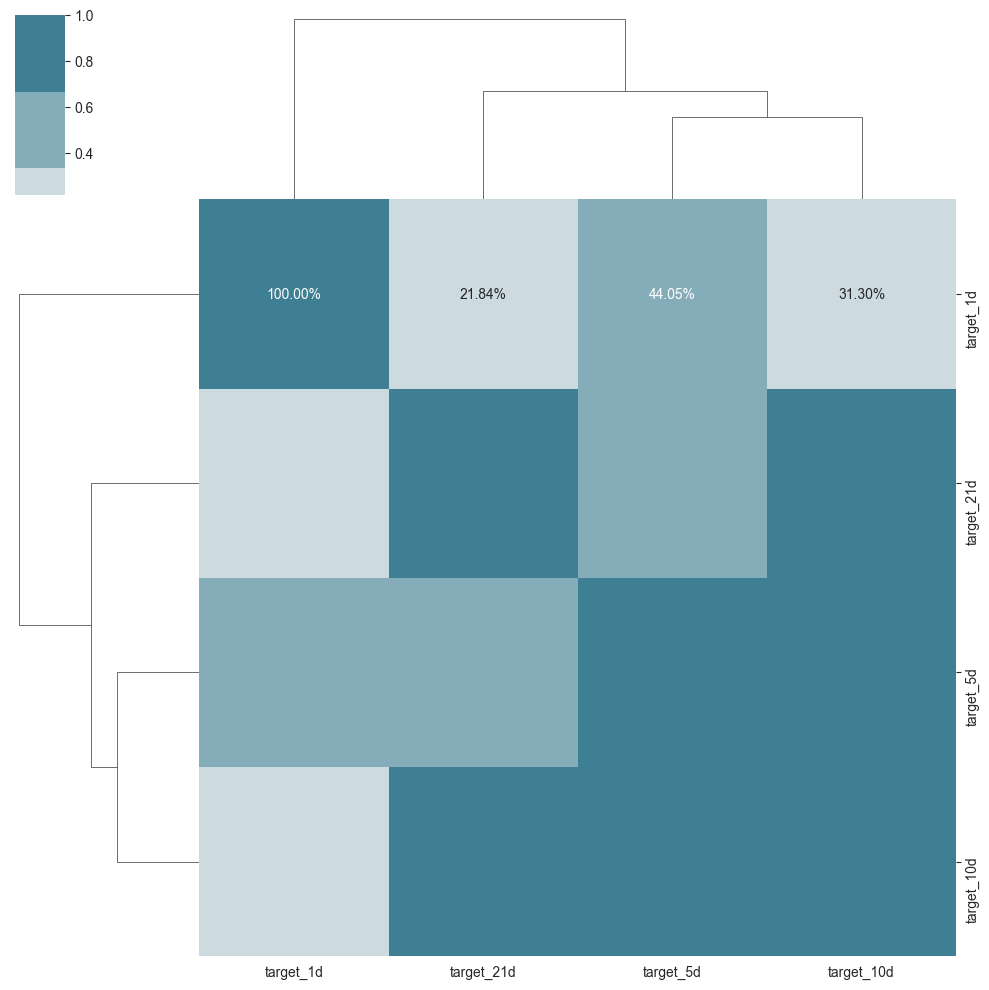

In [4]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

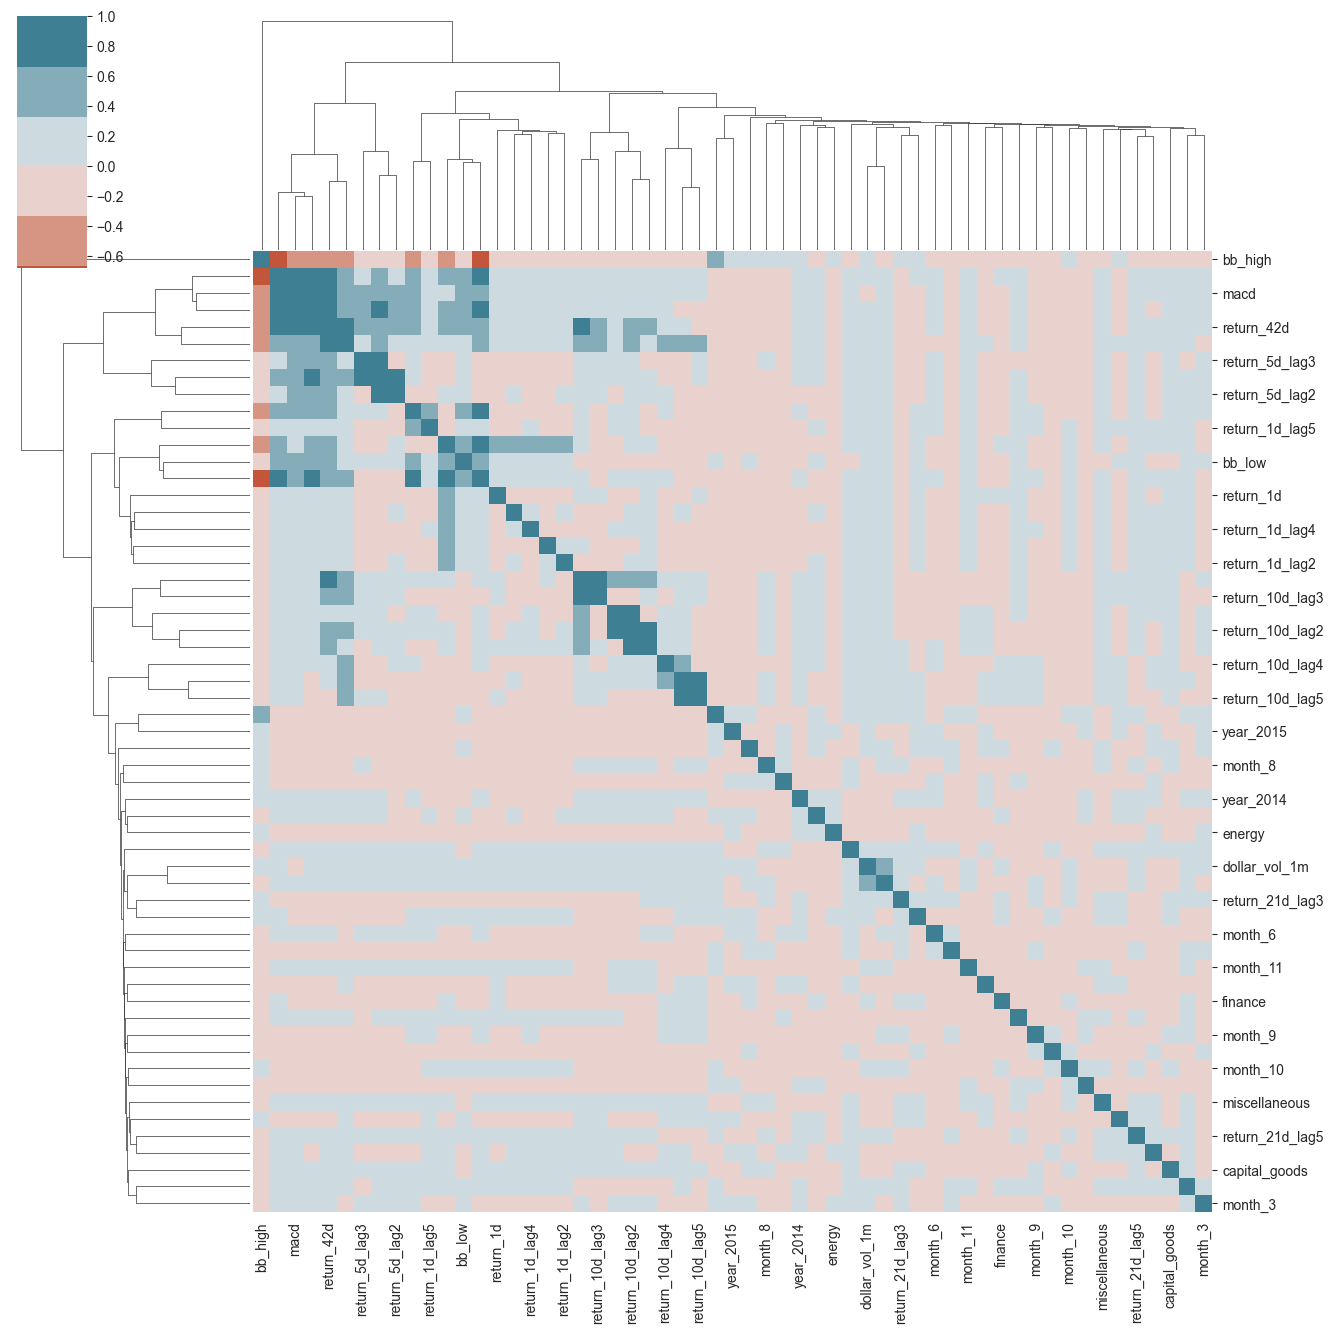

In [5]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

热力图结论：  
热力图显示了特征之间的相关性。  
相关系数的范围在-1到1之间，值越接近1或-1，说明特征之间的相关性越强。  
相关系数为0说明特征之间没有相关性。  

Conclusion of heat map:
The heatmap shows the correlation between features.   
The range of the correlation coefficient is between -1 and 1. The closer the value is to 1 or -1, the stronger the correlation between the features.   
A correlation coefficient of 0 indicates that there is no correlation between the features.   

In [6]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

# corr_mat.head().append(corr_mat.tail())  old code is bad; 作者原始代码已经不行了
pd.concat([corr_mat.head(), corr_mat.tail()])  # pandas ≥ 2.0 good

,var1,var2,corr
581,return_42d,return_63d,0.839924
637,return_63d,return_42d,0.839924
286,macd,rsi,0.820784
62,rsi,macd,0.820784
518,return_21d,macd,0.793004
515,return_21d,bb_high,-0.608551
122,bb_high,return_10d,-0.677111
458,return_10d,bb_high,-0.677111
59,rsi,bb_high,-0.682076
115,bb_high,rsi,-0.682076


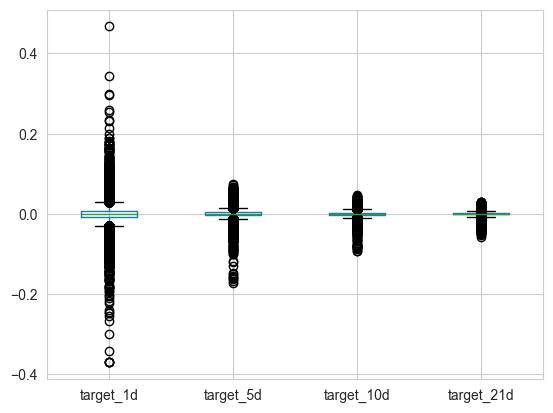

In [7]:
y.boxplot();

### Linear Regression for Statistical Inference: OLS with statsmodels
用statsmodels库进行线性回归分析，OLS线性回归

Ticker-wise standardization

statsmodels warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [8]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

1-Day Returns

In [9]:
target = 'target_1d'
# this is MultiIndex
# model = OLS(endog=y[target], exog=add_constant(X))      # old code is bad; 老代码失效
X = X.astype(float)
model = OLS(endog=y[target], exog=add_constant(X))    # this is good.
trained_model = model.fit()
print(trained_model.summary())

# R-squared is only 0.009, less than 0.5; bad

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.36
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          5.52e-181
Time:                        14:20:47   Log-Likelihood:             2.8809e+05
No. Observations:              109434   AIC:                        -5.761e+05
Df Residuals:                  109376   BIC:                        -5.755e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.573e-

5-Day Returns

In [10]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     60.49
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:20:48   Log-Likelihood:             3.7838e+05
No. Observations:              109434   AIC:                        -7.567e+05
Df Residuals:                  109376   BIC:                        -7.561e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.034e-

Obtain the residuals
计算残差

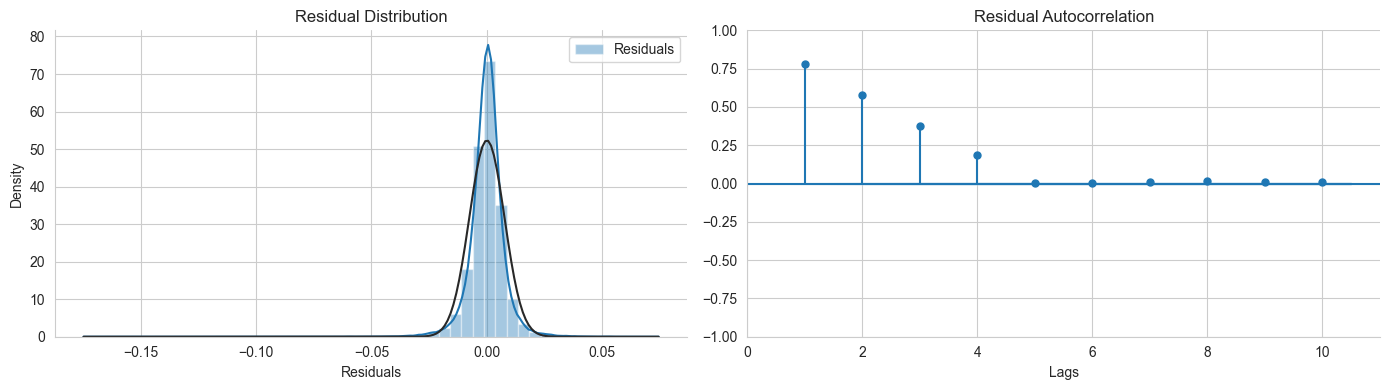

In [11]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

# The residuals are normally distributed, it's good.
# 残差的分布是正态分布，这是好的。
# But the autocorrelation is not good.
# 残差的自相关图不是很好（前几个Lags自相关系数在0.2以上），说明残差之间不是独立的。


10-Day Returns

In [12]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     83.67
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:20:54   Log-Likelihood:             4.1879e+05
No. Observations:              109434   AIC:                        -8.375e+05
Df Residuals:                  109376   BIC:                        -8.369e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.143e-

Monthly Returns

In [13]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

# my conclusion 我的结论
# days increase, R-squared increase. model is more accurate.
# 天数增加，R-squared增加，模型更准确。


                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     113.0
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:20:55   Log-Likelihood:             4.6176e+05
No. Observations:              109434   AIC:                        -9.234e+05
Df Residuals:                  109376   BIC:                        -9.229e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00